# Security Characteristic Line  Analysis (Time Series Regression)
**Authors:** Brandon Pover (bnp669), MC Kreps (mck678), Jonathan Jan (jj39582)

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import statsmodels.api as sm
import pandas_datareader as web
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import yfinance as yf # need to download yfinance first (pip install yfinance)
from datetime import datetime
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Get Data

**Source:**
- Stock: https://finance.yahoo.com/quote/AAPL/history?p=AAPL
- Rf: https://finance.yahoo.com/quote/%5EIRX/history?p=%5EIRX
- Market Proxy: https://finance.yahoo.com/quote/SPY/history?p=SPY

In [2]:
# Query the user for necessary information to provide analysis
def get_data():
    ticker = input('Please enter ticker of firm to analyze: ')
    mark_prox = input('Please enter ticker of market proxy ETF/fund: ')
    start = input('Please enter start date to analyze in format "YYYY-MM-DD": ')
    end = input('Please enter end date to analyze in format "YYYY-MM-DD": ')
    freq = input('Please enter frequency of returns to analyze (i.e., 15m, 1h, 5d, 1wk, 1mo): ')
    
    #download data from yahoo finance
    data = yf.download(f'{ticker} {mark_prox} ^IRX',start = start,end=end,interval = freq)
    return data, freq, ticker, mark_prox, start, end
data,freq, ticker, mark_prox, start, end = get_data()

Please enter ticker of firm to analyze: AAPL
Please enter ticker of market proxy ETF/fund: SPY
Please enter start date to analyze in format "YYYY-MM-DD": 2016-01-01
Please enter end date to analyze in format "YYYY-MM-DD": 2020-12-31
Please enter frequency of returns to analyze (i.e., 15m, 1h, 5d, 1wk, 1mo): 1mo
[*********************100%***********************]  3 of 3 completed


## Clean data & Calculate Risk Premia

In [3]:
def clean_data(data):
    # Use close price as a proxy for stock/market price
    data = pd.DataFrame(data['Close'])
    # month and week freq have particular format
    if freq[-1] == 'k' or freq[-1] == 'o':
        data.dropna(axis=0,how='all',inplace=True)
        data[f'{ticker}'] = data[f'{ticker}'].interpolate(method='linear')
        data[f'{mark_prox}'] = data[f'{mark_prox}'].interpolate(method='linear')
        data['^IRX'] = data['^IRX'].interpolate(method='linear')
    else:
        data[f'{ticker}'] = data[f'{ticker}'].interpolate(method='linear')
        data[f'{mark_prox}'] = data[f'{mark_prox}'].interpolate(method='linear')
        data['^IRX'] = data['^IRX'].interpolate(method='linear')
        data.dropna(axis=0,how='any',inplace=True)
    return data
data = clean_data(data)

In [4]:
def risk_premia(data):
    #calculate the monthly return
    stock_ret = data[f'{ticker}'].pct_change()
    mark_ret = data[f'{mark_prox}'].pct_change()
    
    # convert into percent
    data['^IRX'] = data['^IRX']/100
    
    # add returns 
    data['Stock Returns'] = stock_ret
    data['Market Returns'] = mark_ret
    
    # format returns
    data['Stock Returns'] = data['Stock Returns'].apply(lambda x: float(x))
    data['Market Returns'] = data['Market Returns'].apply(lambda x: float(x))
    data['^IRX'] = data['^IRX'].apply(lambda x: float(x))
    
    #calculate risk premium of the stock and the market risk premium.
    data['Stock Premia'] = data['Stock Returns'] - data['^IRX']
    data['Market Premia'] = data['Market Returns'] - data['^IRX']
    
    return data,stock_ret,mark_ret
data, stock_ret, mark_ret = risk_premia(data)

## Regression & Exploratory Analysis

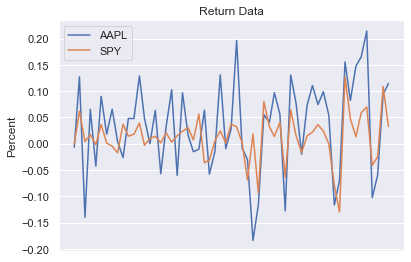

In [5]:
#plotting return data 
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(stock_ret,label=f'{ticker}',)
ax1.plot(mark_ret,label=f'{mark_prox}')
ax1.legend(loc='best')
ax1.set_xlabel("Date")
ax1.set_ylabel("Percent")
ax1.set_title("Return Data")
ax1.axes.get_xaxis().set_visible(False)
plt.show()

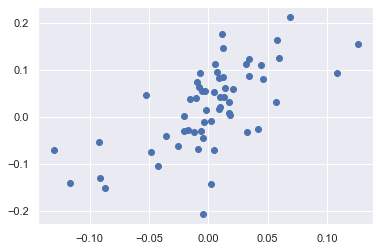

In [6]:
#scatter plot for risk premium of the stock and the market risk premium.
x = np.array(data['Market Premia'][1:])
y = np.array(data['Stock Premia'][1:])
plt.scatter(x,y)

In [7]:
def time_series_regress(data,x,y)  :
    #time series regression with summary statistics
    import statsmodels.formula.api as smf
    d = { "x": pd.Series(x), "y": pd.Series(y)}
    df = pd.DataFrame(d)
    mod = smf.ols('y ~ x', data=df)
    res = mod.fit()
    print(res.summary())
    
    #2nd time series regression for ease of statistic pulling
    x = np.array(data['Market Premia'][1:]).reshape((-1,1))
    y = np.array(data['Stock Premia'][1:])
    model = LinearRegression()
    model = model.fit(x,y)
    
    # Print out relevant statistics
    print('Summary Statistics')
    print('-'*90)
    print(f'The number of observations in the regression is: ',len(data)-1)
    print('The correlation of the risk premia of the market and your stock is: ',round(model.score(x,y)**(1/2),4))
    print('The R-squared of the regression for the SCL is: ',round(model.score(x,y),3))
    print('The Adjused R-squared of the regression for the SCL is: ',round(1 - (1-model.score(x, y))*(len(y)-1)/(len(y)-x.shape[1]-1),3))
    print('The standard error of the regression is: ',round(res.scale**.5,5))
    print('The t-test value of the alpha is: ',round((res.params[0]-0)/res.bse[0],3))
    if round((res.params[0]-0)/res.bse[0],3) >= 2:
        print('\tThe alpha is statistically different from 0')
    else:
        print('\tThe alpha is NOT statistically significant from 0.\n\tCAPM assumption satisfied.')
    print('The t-test value of the beta is: ',round((res.params[1]-1)/res.bse[1],3))
    if round((res.params[1]-1)/res.bse[1],3) >= 2:
        print('\tThe beta is statistically different from 1')
    else:
        print('\tThe beta is NOT statistically significant from 1.\n\tCAPM assumption satisfied.')
    
    return model, res
model, res = time_series_regress(data,x,y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     43.28
Date:                Wed, 27 Oct 2021   Prob (F-statistic):           1.60e-08
Time:                        16:20:39   Log-Likelihood:                 76.751
No. Observations:                  59   AIC:                            -149.5
Df Residuals:                      57   BIC:                            -145.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0204      0.009      2.334      0.0

**Notes**
- The t-test of the alpha (intercept) is statistically different from 0, meaning that AAPL has above average returns that cannot be explained as compensation for added risk.
- The t-test of the beta (coefficient) is not statistically different than 1, meaning that AAPL likely will not be useful in divserifying away from market risk as it his heavily influenced by the market.

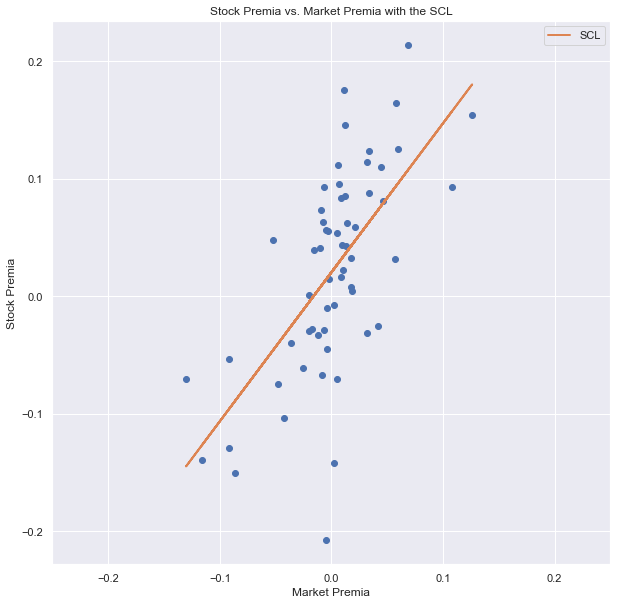

In [8]:
predicted = model.predict(x.reshape(-1,1))
# Plot stock and market premia with SCL line
plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
ax.plot(x, y, 'o')
ax.plot(x, predicted, '-', lw=2, label = "SCL")
ax.legend(loc='best')
ax.set_title('Stock Premia vs. Market Premia with the SCL')
ax.set_xlabel('Market Premia')
ax.set_ylabel('Stock Premia')
ax.set_xlim([-.25,.25])
plt.show()

## Checking Assumptions of Linear Regression

### Linearity

In [9]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    return df_results

In [10]:
def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=7)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max(),.01)
    plt.plot(line_coords, line_coords, color='darkorange', linestyle='-')
    plt.title('Actual vs. Predicted')
    plt.show()

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


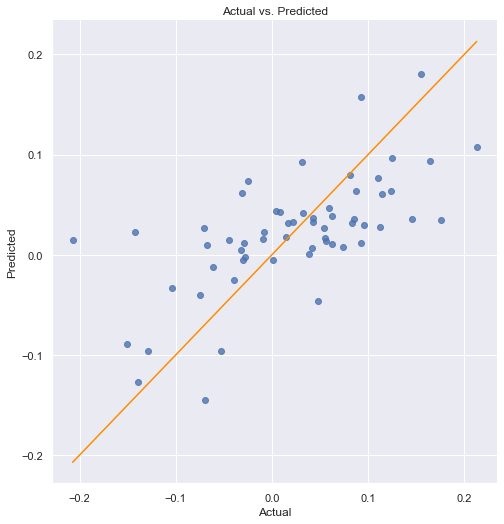

In [11]:
linear_assumption(model, x.reshape(-1,1), y)

- This is a case where it is not a perfectly linear relationship. Our predictions vs. actual graphic tends to deviate on the lower end (less than -.1), but remains relatively evenly distributed around the line thereafter. If we had more data, perhaps the relationship would be more clear and give a better analysis of this linear assumption.

### Normality of Error Terms

In [12]:
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.36752772271595385
Residuals are normally distributed


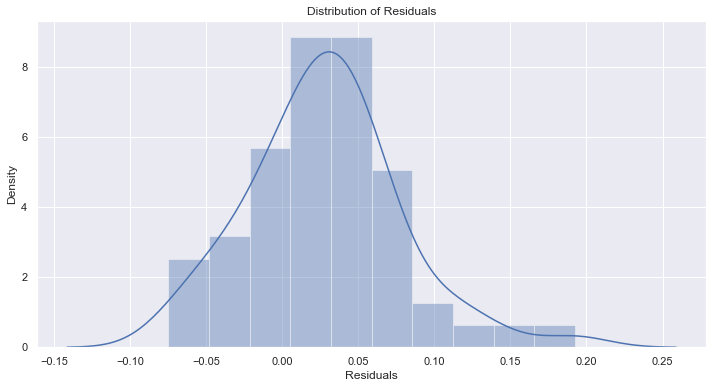


Assumption satisfied


In [13]:
normal_errors_assumption(model, x.reshape(-1,1), y)

- As you can see in the distribution above, the residuals are normally distributed around .025 with a small amount of right-hand skewness. A nonlinear transformation of the inputs might be able to fix the slight skew if needed, but it is likely from the low amount of observations.

### No Autocorrelation of the Error Terms 

In [14]:
def autocorrelation_assumption(model, features, label):
    """
    Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                     autocorrelation, then there is a pattern that is not explained due to
                     the current value being dependent on the previous value.
                     This may be resolved by adding a lag variable of either the dependent
                     variable or some of the predictors.
    """
    from statsmodels.stats.stattools import durbin_watson
    print('Assumption 4: No Autocorrelation', '\n')
    
    # Calculating residuals for the Durbin Watson-tests
    df_results = calculate_residuals(model, features, label)

    print('\nPerforming Durbin-Watson Test')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')

In [16]:
autocorrelation_assumption(model, x.reshape(-1,1), y)

Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.6048696557007867
Little to no autocorrelation 

Assumption satisfied


- As you can see, there is little to no autocorrelation present in the error terms. This indicates that we have all necessary information that should be captured by the model and our residuals are not related over time.

### Homoscedasticity

In [18]:
def homoscedasticity_assumption(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show()  

Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


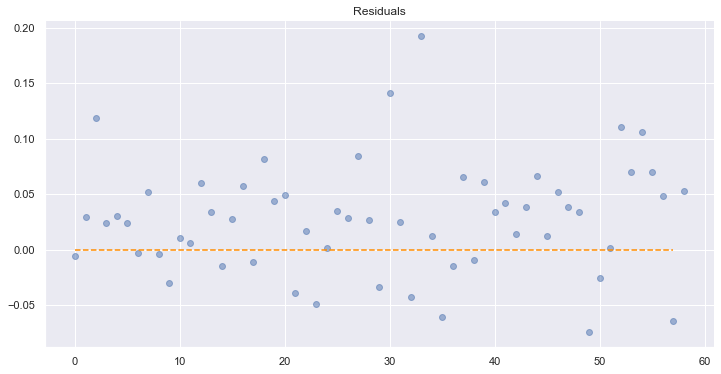

In [19]:
homoscedasticity_assumption(model, x.reshape(-1,1), y)

- There appears to be some heteroskedasticity in the error terms as the variance in negative residuals appears to be smaller on average than positive residuals. There is also the fact that they form a slight cone shape going from smaller to larger. As a result, it might be beneficial to apply a log transformation on the depedent variable to remove any evidence of hetertoskedasticity.